In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from resources.plotting import Plotter
from tqdm.autonotebook import tqdm

from nltk.tokenize import WordPunctTokenizer

from rouge_score.rouge_scorer import RougeScorer
from resources.bart_score import BARTScorer
from resources.auc_score import AUCScorer
from resources.testing import PearsonCorrelationTester
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
MODELS = {
    "Gemma 1.1 - 2B": "google/gemma-1.1-2b-it",
    "Gemma 1.1 - 7B": "google/gemma-1.1-7b-it",
    "Gemma 2.0 - 9B": "google/gemma-2-9b-it",
#    "Gemma 2.0 - 27B":  "google/gemma-2-27b-it",
    "Llama 3.1 - 8B": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "Llama 3.2 - 1B": "meta-llama/Llama-3.2-1B-Instruct",
    "Llama 3.2 - 3B": "meta-llama/Llama-3.2-3B-Instruct",
#    "DeepSeek-R1 Llama - 8B": "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
}
LABELS = np.array(['allergens', 'biological', 'foreign bodies', 'chemical', 'organoleptic aspects', 'fraud'], dtype=object)

PLOTS_DIR  = "plots"

# Load results:

In [3]:
RESULTS = {}

for key in MODELS:
    t_start = time.time()
    with open(f'results/food incidents - hazard/{MODELS[key]}.pkl', 'rb') as file:
        RESULTS[key] = pickle.load(file)
    print(f'Loaded {key} ({len(RESULTS[key]):d} instances, dt={(time.time()-t_start)*1000:.2f} ms).')

Loaded Gemma 1.1 - 2B (200 instances, dt=953.91 ms).
Loaded Gemma 1.1 - 7B (200 instances, dt=947.69 ms).
Loaded Gemma 2.0 - 9B (200 instances, dt=899.29 ms).
Loaded Llama 3.1 - 8B (200 instances, dt=933.94 ms).
Loaded Llama 3.2 - 1B (200 instances, dt=1098.41 ms).
Loaded Llama 3.2 - 3B (200 instances, dt=948.35 ms).


In [4]:
pearson = PearsonCorrelationTester()
plotter = Plotter(RESULTS, i_sample=8, save_dir=PLOTS_DIR)
plotter = Plotter(RESULTS, save_dir=PLOTS_DIR)
scorer  = AUCScorer(RESULTS)
plotter.print_chat("Llama 3.1 - 8B")

\begin{tabular}{p{.05\linewidth}p{.1\linewidth}p{.8\linewidth}}

\hline

&
\textbf{user}: &
\texttt{What is the reason for the recall of the food product in the following announcement?

"President's Choice brand Beefless Undeniable Burgers recalled due to presence of pieces of wood"

Assign one of the following labels: "biological", "allergens", "chemical", "foreign bodies", "organoleptic aspects", or "fraud". Make sure to answer only with the label or "none" if none of them applies.} \\

&
\textbf{assistant}: &
\texttt{"foreign bodies"} \\


\hline

&
\textbf{user}: &
\texttt{What is the most important phrase of the announcement influencing your assessment? Provide only the phrase as a string.} \\

&
\textbf{assistant}: &
\texttt{"presence of pieces of wood"} \\


\hline

&
\textbf{user}: &
\texttt{Provide a version of the announcement that would alter your assessment to "chemical" while changing as few words in the original announcement as possible.} \\

&
\textbf{assistant}: &
\text

# Performance:

In [5]:
for model in RESULTS:
    y_true = np.array([''.join(item['label']['tokens']) for item in RESULTS[model]])
    y_pred = np.array([''.join(item['prediction']['text']) for item in RESULTS[model]])

    ls = np.unique(y_true)
    y_true = np.array([y_true == l for l in ls]).T
    y_pred = np.array([y_pred == l for l in ls]).T
    
    print(model)
    print(f'  F1:           {f1_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  precision:    {precision_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  recall:       {recall_score(y_true, y_pred, average="macro"):.2f}')
    print()

Gemma 1.1 - 2B
  F1:           0.28
  precision:    0.42
  recall:       0.22

Gemma 1.1 - 7B
  F1:           0.48
  precision:    0.61
  recall:       0.48

Gemma 2.0 - 9B
  F1:           0.53
  precision:    0.63
  recall:       0.51

Llama 3.1 - 8B
  F1:           0.44
  precision:    0.43
  recall:       0.45

Llama 3.2 - 1B
  F1:           0.02
  precision:    0.18
  recall:       0.01

Llama 3.2 - 3B
  F1:           0.17
  precision:    0.46
  recall:       0.12



/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/

# Faithfullness:

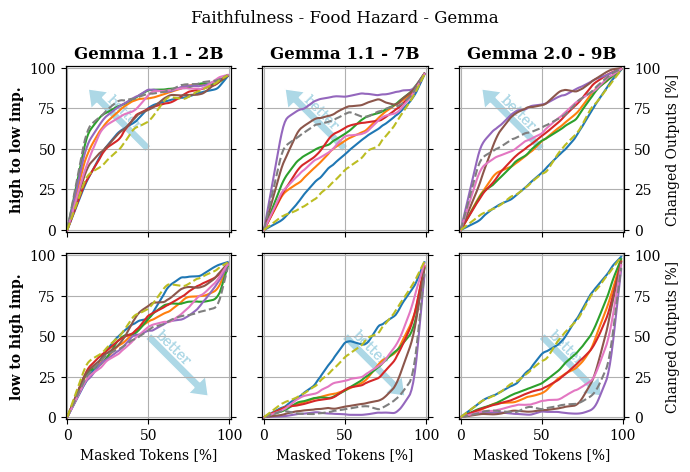

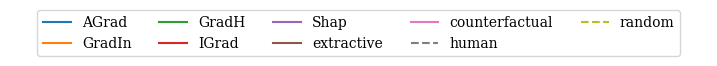

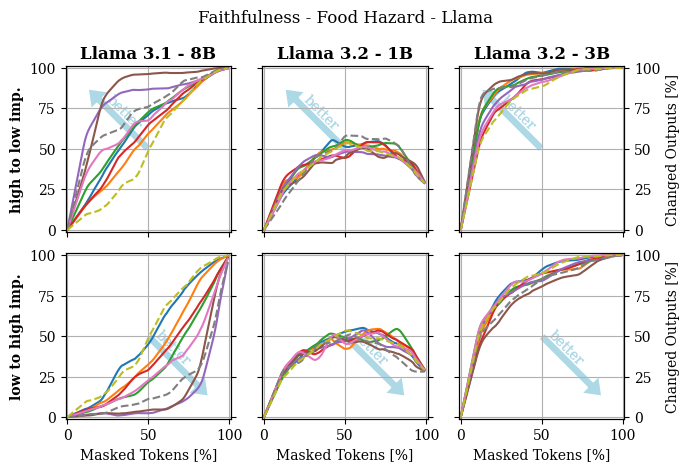

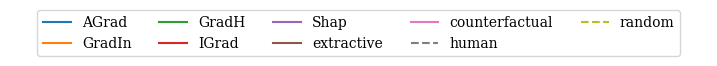

,Gemma 1.1 - 2B,Gemma 1.1 - 7B,Gemma 2.0 - 9B,Llama 3.1 - 8B,Llama 3.2 - 1B,Llama 3.2 - 3B
AGrad,0.037953,0.048299,-0.010482,0.127478,-0.001190,0.062791
GradIn,0.191591,0.277638,0.292174,0.148472,0.010042,0.095010
GradH,0.222807,0.340868,0.235304,0.319766,0.011436,0.076803
IGrad,0.075052,0.327970,0.315035,0.223433,0.004117,0.040384
Shap,0.251380,0.691811,0.645664,0.663906,0.004706,0.054613
human,0.278181,0.552389,0.516382,0.528196,0.042658,0.116666
extractive,0.071944,0.532512,0.559744,0.659364,0.005780,0.160976
counterfactual,0.204437,0.249200,0.442808,0.366020,-0.005850,0.010332


In [6]:
plotter.plot_perturbation('Faithfulness - Food Hazard')
scorer.score_table()

Gemma 1.1 - 2B

In [7]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 1.1 - 2B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['the reason for the recall is not specified in the', '1600']],
      dtype='<U49')

Gemma 1.1 - 7B

In [8]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 1.1 - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['foreign bodies', '208'],
       ['foreign bodies<eos>', '200'],
       ['the provided text is not included in the prompt,', '1192']],
      dtype='<U48')

Gemma 2.0 - 9B

In [9]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 2.0 - 9B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['please provide the announcement so i can determine the reason',
        '1600']], dtype='<U61')

Llama 3.1 - 8B

In [10]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.1 - 8B"] for key in r['perturbation']],
    return_counts=True
)).T

array([["I'm happy to help you with this problem!", '8'],
       ["I'm happy to help! However, I don", '352'],
       ["I'm not able to read the announcement you provided", '296'],
       ["I'm not able to view the announcement you're", '768'],
       ["I'm ready to help. Please go ahead and", '56'],
       ["I'm sorry, but I am unable to process", '112'],
       ['There is no announcement provided. Please provide the announcement',
        '8']], dtype='<U66')

Llama 3.2 - 1B

In [11]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.2 - 1B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['biological<|eot_id|>', '120'],
       ['none<|eot_id|>', '1480']], dtype='<U21')

Llama 3.2 - 3B

In [12]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.2 - 3B"] for key in r['perturbation']],
    return_counts=True
)).T

array([["I can't provide a response with only a number", '16'],
       ["I don't see an announcement provided. Please share", '368'],
       ["I'm ready to help. However, I don", '56'],
       ["I'm ready to help. What is the announcement", '1160']],
      dtype='<U50')

# Self assessment:

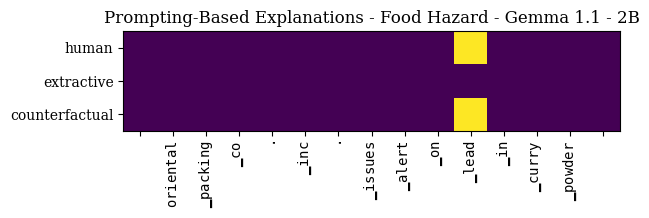

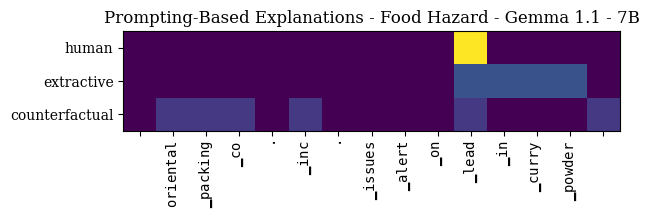

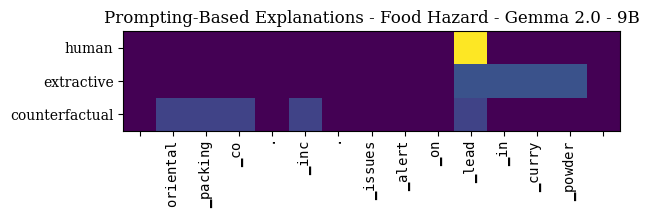

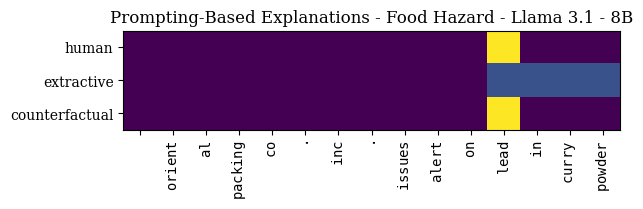

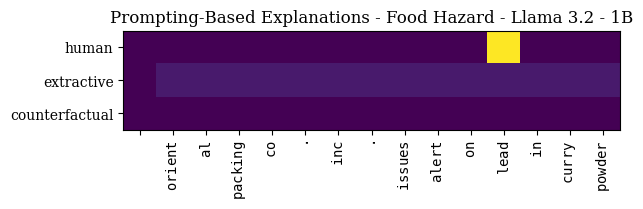

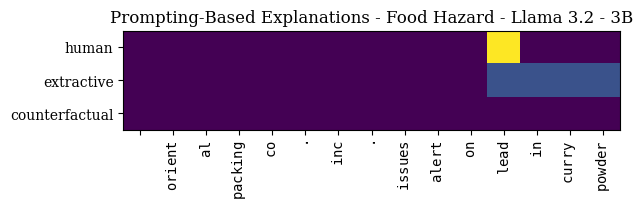

In [13]:
importance_human = {model:[] for model in RESULTS}
importance_self  = {model:[] for model in RESULTS}
importance_cf    = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']
        
        importance_human[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['human']: 
            importance_human[model][-1][i-offset:j-offset] = 1.
        importance_human[model][-1] /= max(importance_human[model][-1].sum(), 1e-9)
        
        importance_self[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['extractive'][:len(r['spans']['human'])]:
            importance_self[model][-1][i-offset:j-offset] = 1.
        importance_self[model][-1] /= max(importance_self[model][-1].sum(), 1e-9)
        
        importance_cf[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['counterfactual']:
            importance_cf[model][-1][i-offset:j-offset] = 1.
        importance_cf[model][-1] /= max(importance_cf[model][-1].sum(), 1e-9)

plotter.plot_importance([importance_human, importance_self, importance_cf], ['human', 'extractive', 'counterfactual'], f'Prompting-Based Explanations - Food Hazard')
pearson.add(importance_human, 'human')
pearson.add(importance_self,  'extractive')
pearson.add(importance_cf,    'counterfactual')

# AGrad:

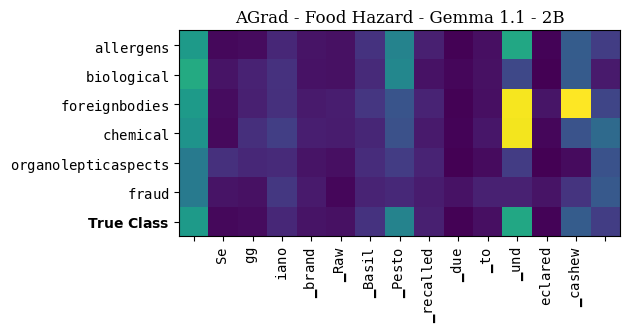

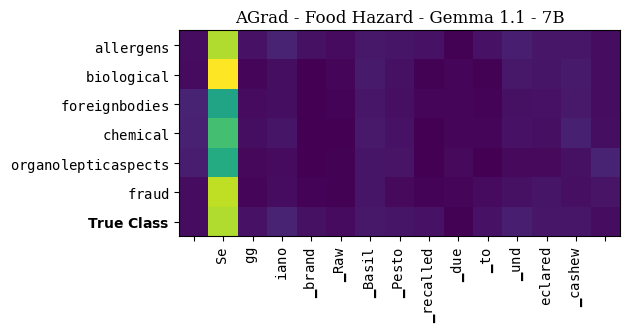

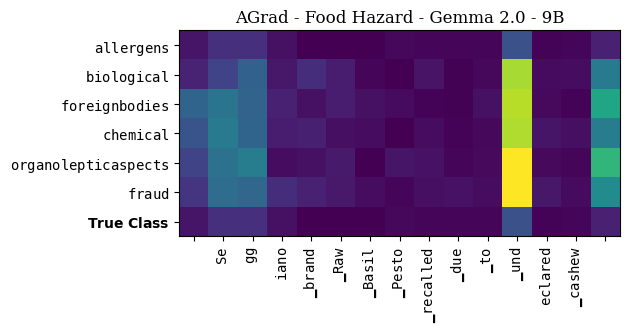

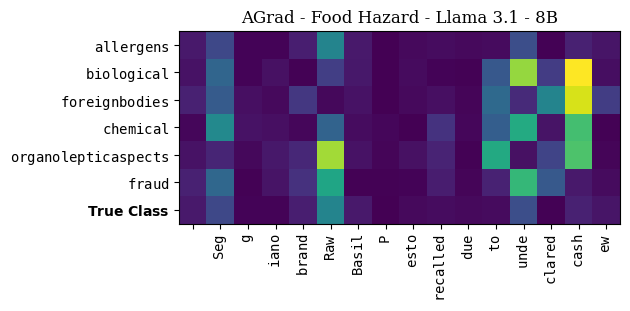

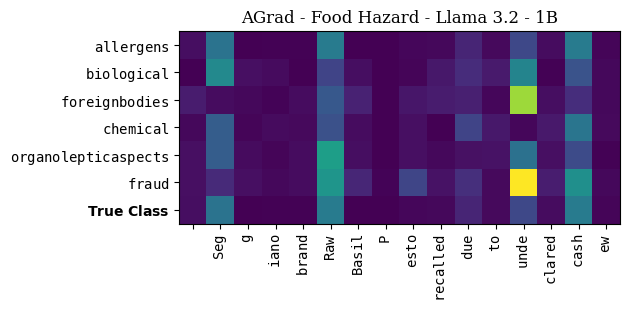

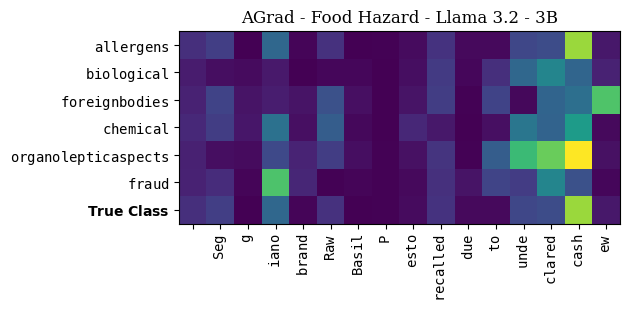

In [14]:
importance_agrad_raw = {model:[] for model in RESULTS}
importance_agrad_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']

        # get importance:
        importance = np.abs(r['AGrad'][:, :, x_start:x_end].mean(axis=0))

        # per token in label:
        importance_agrad_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_agrad_cls[model].append(importance_agrad_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_agrad_raw, importance_agrad_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'AGrad - Food Hazard')
pearson.add(importance_agrad_cls, 'AGrad')

# GradIn

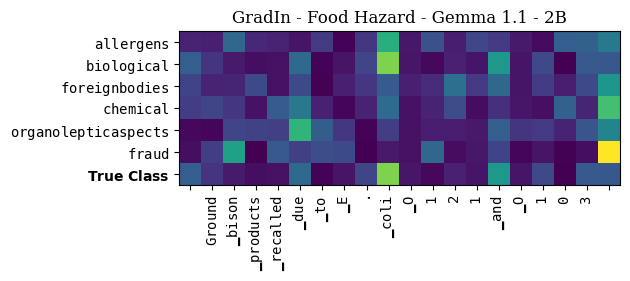

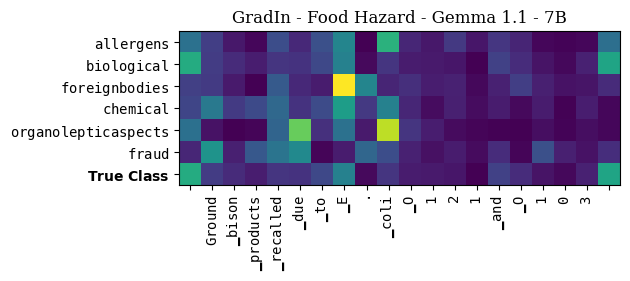

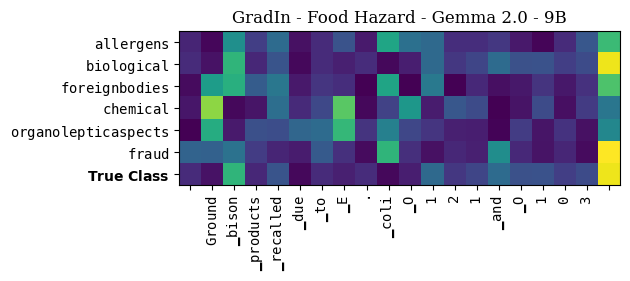

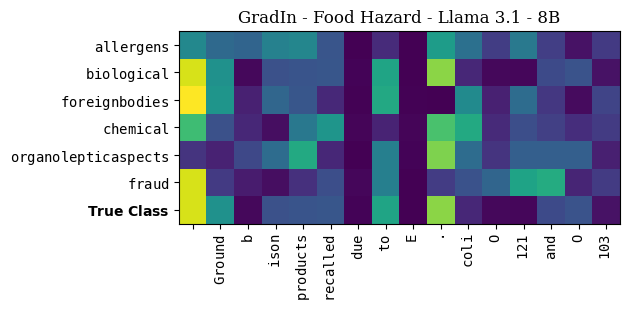

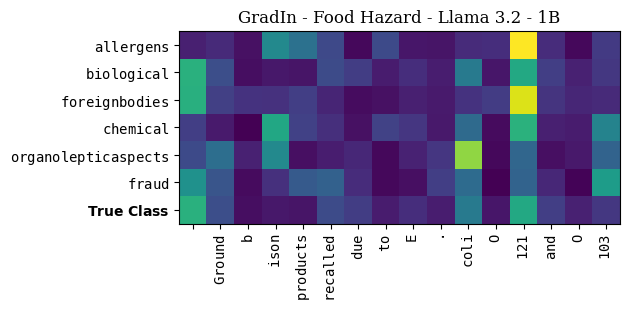

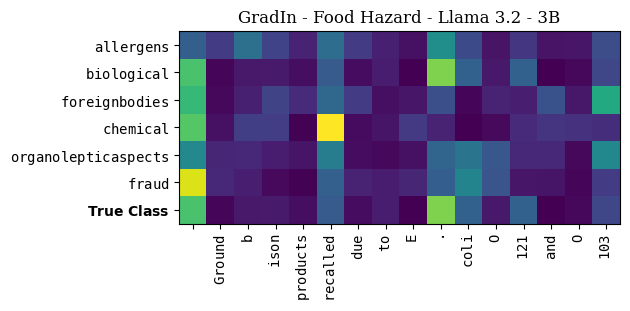

In [15]:
importance_gradin_raw = {model:[] for model in RESULTS}
importance_gradin_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']
    
        # get importance:
        importance = np.abs(r['GradIn'][:, start:end])
    
        # per token in label:
        importance_gradin_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_gradin_cls[model].append(importance_gradin_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_gradin_raw, importance_gradin_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'GradIn - Food Hazard')
pearson.add(importance_gradin_cls, 'GradIn')

# GradH

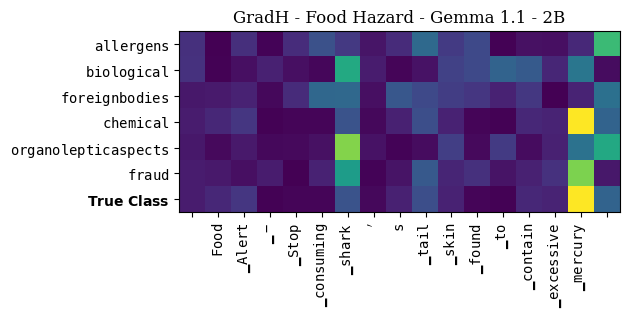

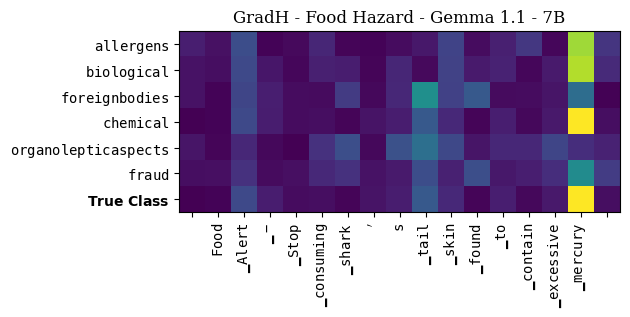

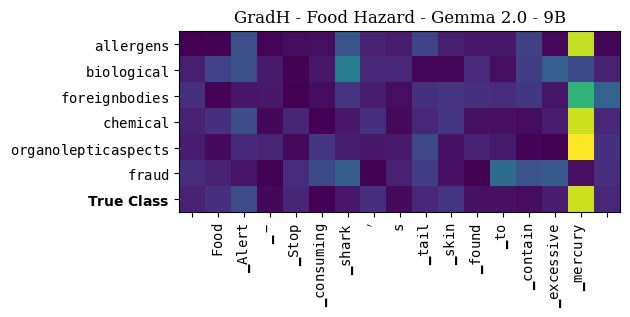

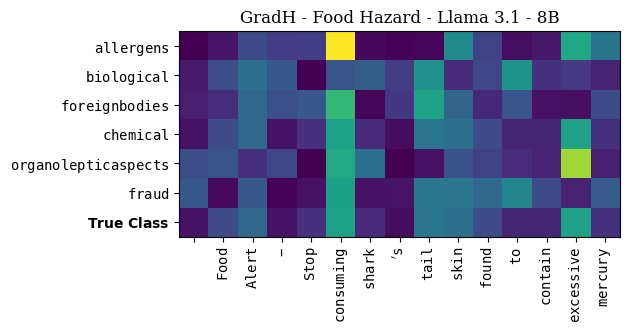

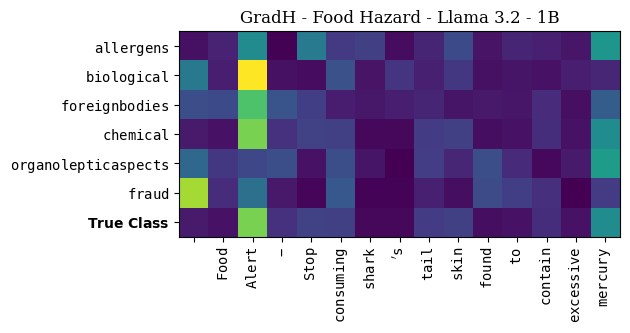

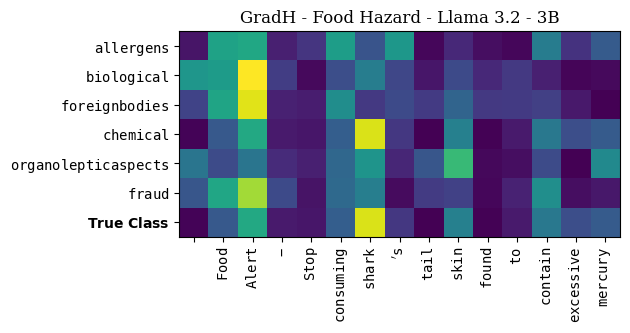

In [16]:
importance_gradh_raw = {model:[] for model in RESULTS}
importance_gradh_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']
    
        # get importance:
        importance = np.abs(r['GradH'][:, start:end])
    
        # per token in label:
        importance_gradh_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_gradh_cls[model].append(importance_gradh_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_gradh_raw, importance_gradh_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'GradH - Food Hazard')
pearson.add(importance_gradh_cls, 'GradH')

# Grad$^{-1}$

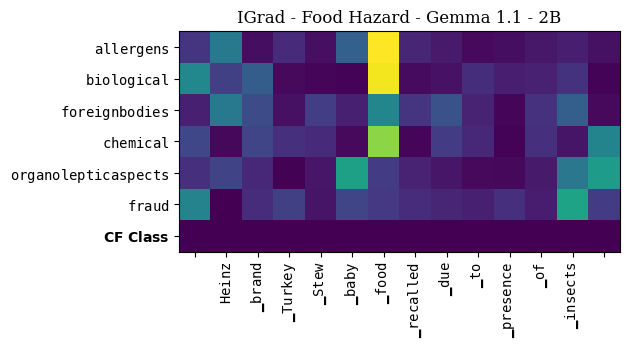

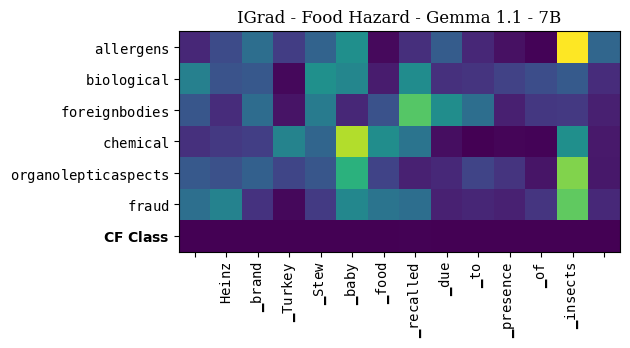

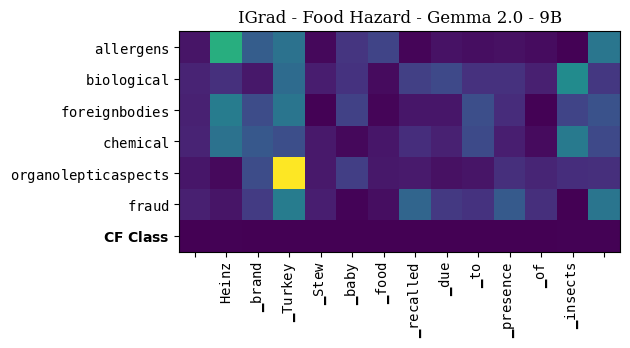

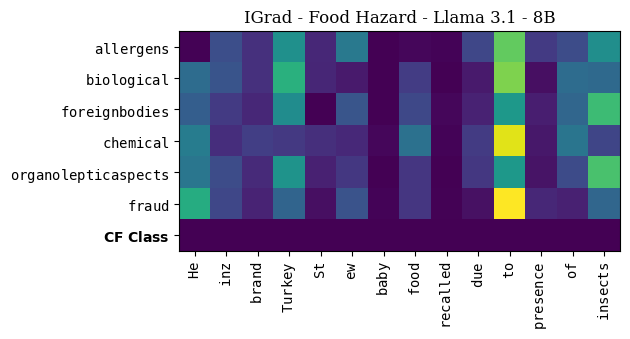

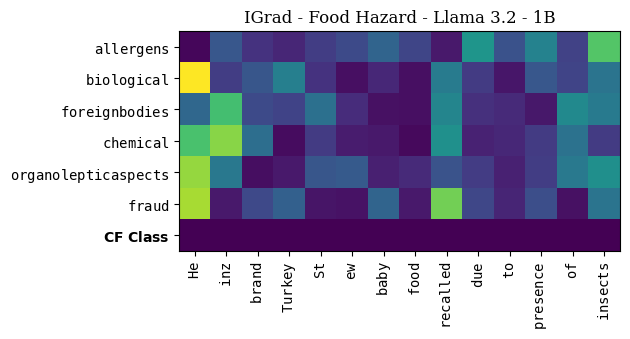

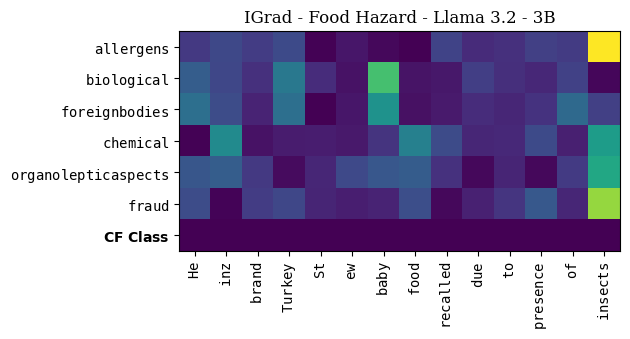

In [17]:
importance_igrad_raw = {model:[] for model in RESULTS}
importance_igrad_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']

        # get counterfactual label:
        cf    = r['counterfactual']['target_label']

        # get importance:
        importance = np.abs(r['IGrad'][:,start:end,:].mean(axis=-1))

        importance_igrad_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only counterfactual class:
        importance_igrad_cls[model].append(importance_igrad_raw[model][-1][cf])

#        # create counterfactual text:
#        original = np.zeros(importance.shape[1:], dtype=float)
#        for i, token in enumerate(r['tokens'][start:end]):
#            original[i, r['IGrad-tokens'][:1024].index(token)] = 1.
#
#        print(r['prediction']['text'], '->', cf, [r['IGrad-tokens'][i] for i in (original - importance[LABELS == cf][0]).argmax(axis=-1)])

plotter.plot_importance([importance_gradin_raw, importance_igrad_cls], ['', '$\\bf\u007bCF~Class\u007d$'], f'IGrad - Food Hazard')
pearson.add(importance_igrad_cls, 'IGrad')

# Shap:

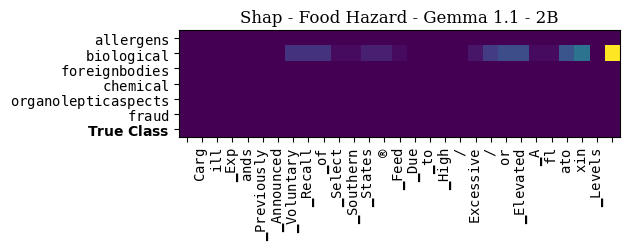

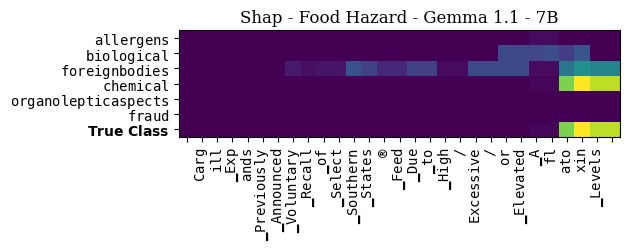

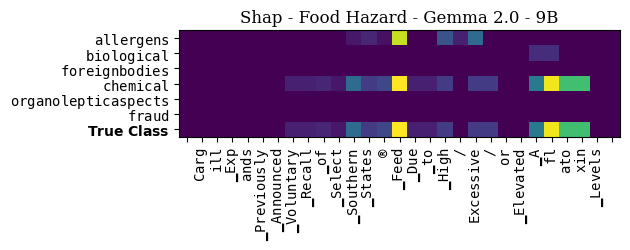

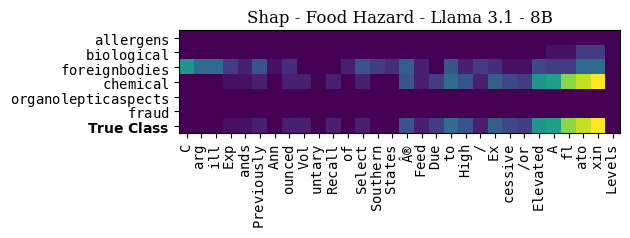

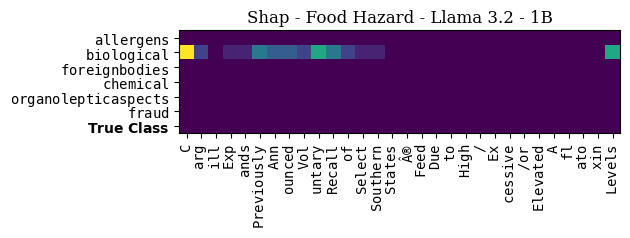

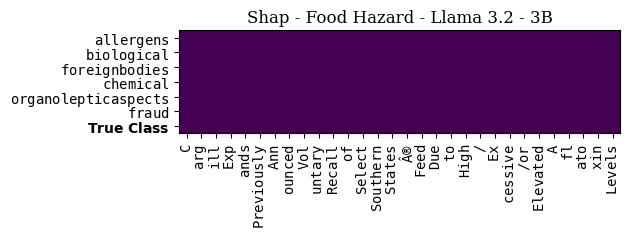

In [18]:
importance_shap_cls = {model:[] for model in RESULTS}
importance_shap_raw = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        if not 'Shap' in r: continue

        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']

        # get importance:
        importance = np.abs(r['Shap'][:, start:end])

        # per token in label:
        importance_shap_raw[model].append({
            LABELS[i]: importance[i,:]
            for i in range(importance.shape[0])
        })

        # only true class:
        importance_shap_cls[model].append(importance_shap_raw[model][-1][r['label']['text']])

plotter.plot_importance([importance_shap_raw, importance_shap_cls], ['', '$\\bf\u007bTrue~Class\u007d$'], f'Shap - Food Hazard')
pearson.add(importance_shap_cls, 'Shap')

/tmp/ipykernel_236751/2557847837.py:1: RuntimeWarning: invalid value encountered in divide
  scale = lambda d: {key: [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in d[key]] for key in d}


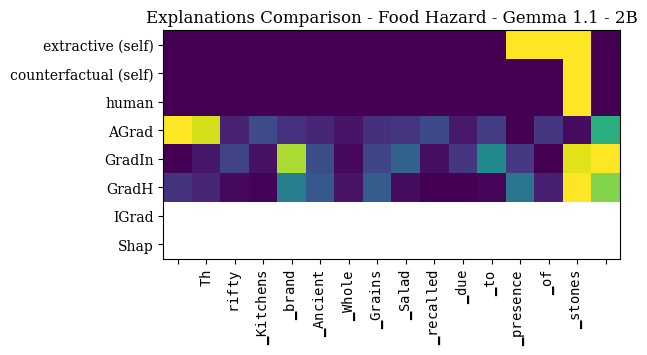

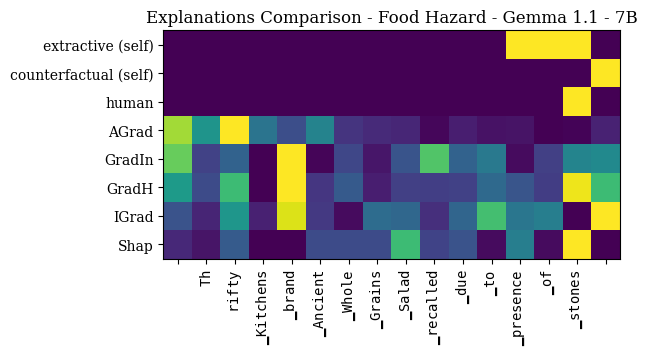

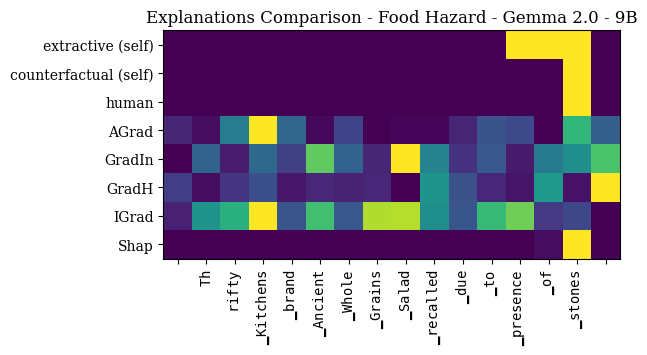

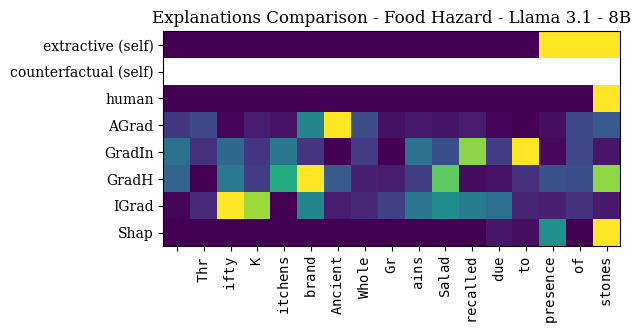

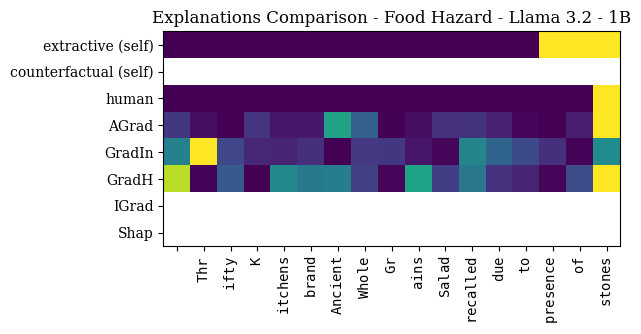

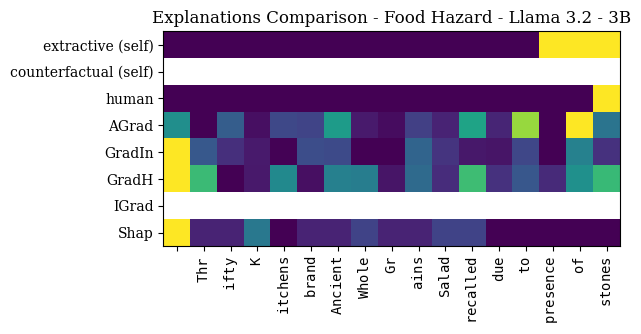

In [19]:
scale = lambda d: {key: [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in d[key]] for key in d}
plotter.plot_importance(
    [
        scale(importance_self),
        scale(importance_cf),
        scale(importance_human),
        scale(importance_agrad_cls),
        scale(importance_gradin_cls),
        scale(importance_gradh_cls),
        scale(importance_igrad_cls),
        scale(importance_shap_cls)
    ],
    ['extractive (self)', 'counterfactual (self)', 'human', 'AGrad', 'GradIn', 'GradH', 'IGrad', 'Shap'],
    f'Explanations Comparison - Food Hazard'
)

# Correlations:

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


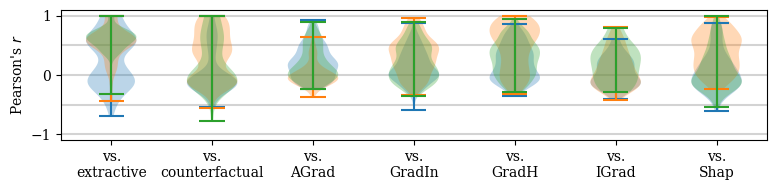

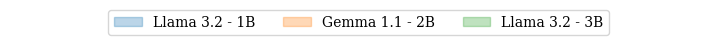

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


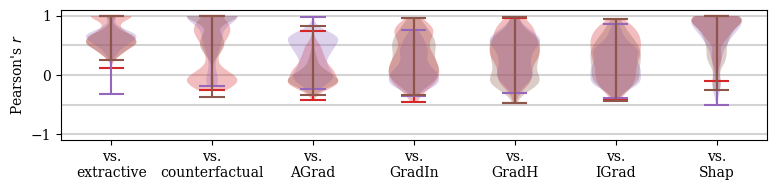

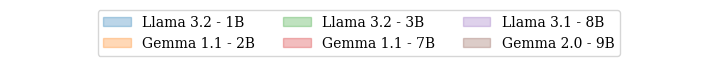

In [20]:
pearson.boxplot('human', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Human.pdf')

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


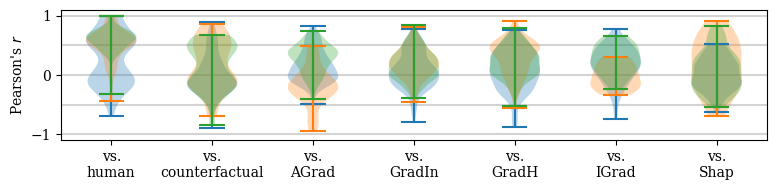

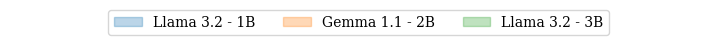

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


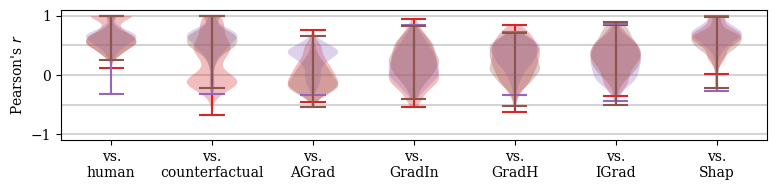

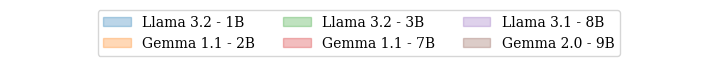

In [21]:
pearson.boxplot('extractive', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Self.pdf')

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


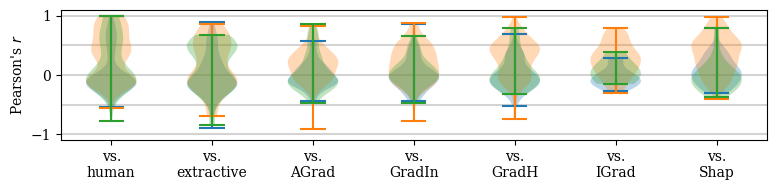

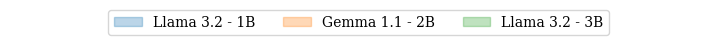

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


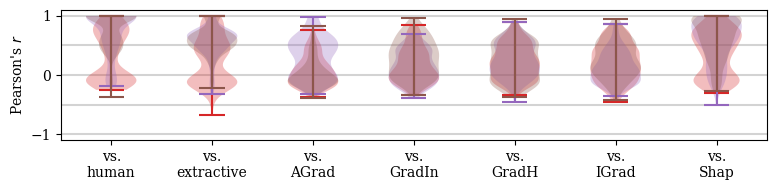

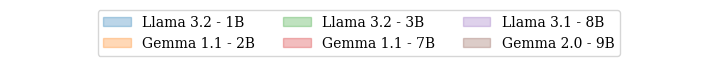

In [22]:
pearson.boxplot('counterfactual', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Counterfactual.pdf')

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


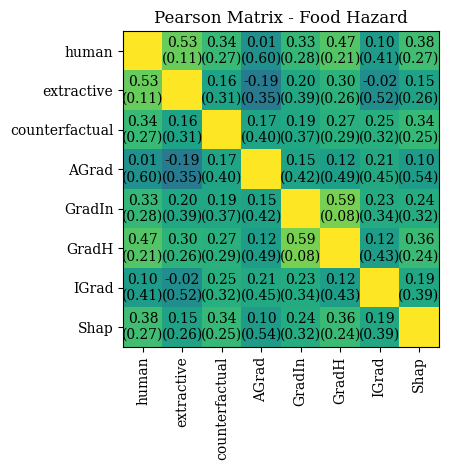

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


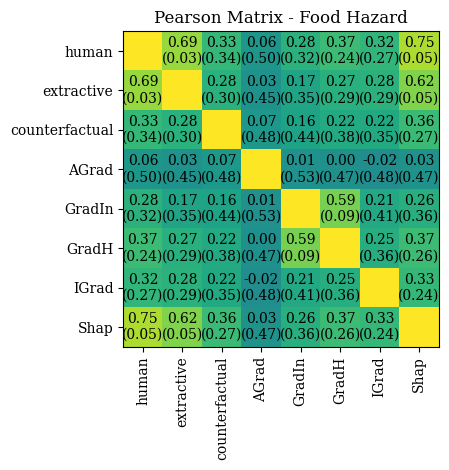

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


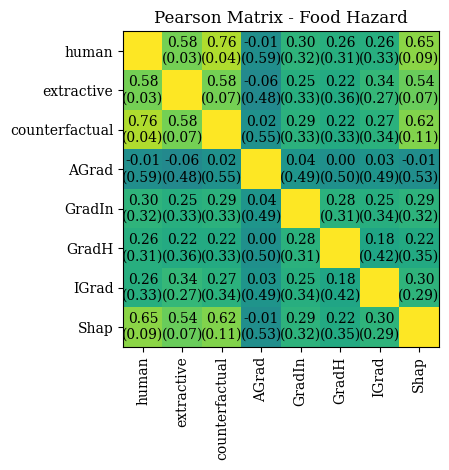

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


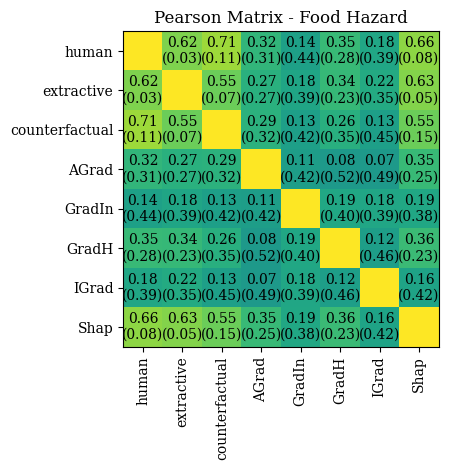

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


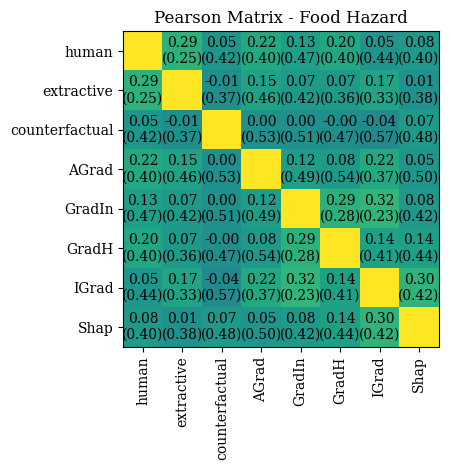

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


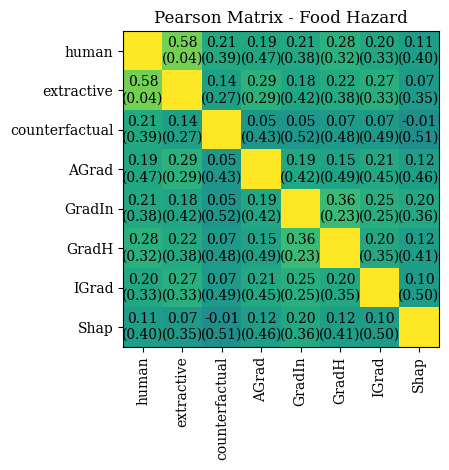

In [23]:
pearson.matrixplot(title='Pearson Matrix - Food Hazard', dir=PLOTS_DIR)

# Counterfactual:

/home/h21/kora8563/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Gemma 1.1 - 2B
  Success rate: 0.94
  Similarity: 0.9447556602282727
  ROUGE-1: 0.7282110753131164
  BLEU-1: 0.670775298601142
  ROUGE-L: 0.6895564582496914
  BART: -2.429511400930425

Gemma 1.1 - 7B
  Success rate: 1.0
  Similarity: 0.9580952373876366
  ROUGE-1: 0.8271542628212901
  BLEU-1: 0.7555130755557764
  ROUGE-L: 0.7834830495600539
  BART: -2.1162849034368993

Gemma 2.0 - 9B
  Success rate: 1.0
  Similarity: 0.9582643595352336
  ROUGE-1: 0.7926051180486512
  BLEU-1: 0.7141861451698333
  ROUGE-L: 0.7494387393796774
  BART: -3.7424407345056534

Llama 3.1 - 8B
  Success rate: 0.945
  Similarity: 0.9203140782400467
  ROUGE-1: 0.8965448398575789
  BLEU-1: 0.6281358880040046
  ROUGE-L: 0.6797634535500908
  BART: -3.0467052220036743

Llama 3.2 - 1B
  Success rate: 0.265
  Similarity: 0.9118241568577272
  ROUGE-1: 0.9526044251759895
  BLEU-1: 0.499493297135519
  ROUGE-L: 0.5927938550113298
  BART: -2.923720730925506

Llama 3.2 - 3B
  Success rate: 0.915
  Similarity: 0.8416912469370174

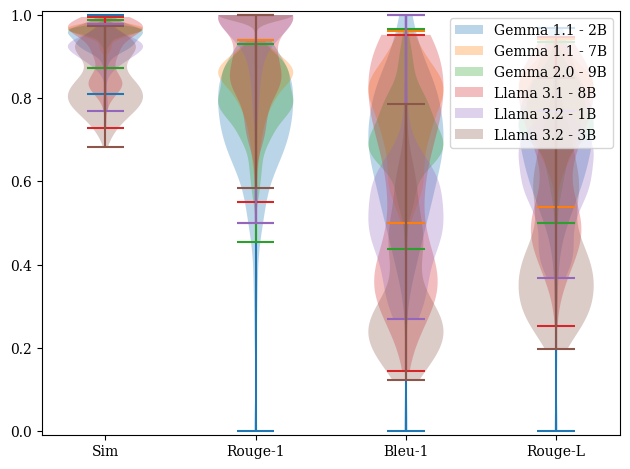

In [24]:
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=WordPunctTokenizer())
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

hs, ls = [], [] 
for model in RESULTS:
    counterfactuals = []

    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']

        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)

        counterfactuals.append((
            int(success),
            cf['similarity'],
            rouge['rouge1'].recall,    # rouge
            rouge['rouge1'].precision, # bleu
            rouge['rougeL'].fmeasure,
            bart[0]
        ))

    counterfactuals = np.array(counterfactuals, dtype=float)

    hs.append(plt.violinplot(counterfactuals[counterfactuals[:,0] == 1., 1:-1])['bodies'][0])
    ls.append(model)

    print(model)
    print('  Success rate:', counterfactuals[:,0].mean())
    print('  Similarity:', counterfactuals[counterfactuals[:,0] == 1., 1].mean())
    print('  ROUGE-1:', counterfactuals[counterfactuals[:,0] == 1., 2].mean())
    print('  BLEU-1:', counterfactuals[counterfactuals[:,0] == 1., 3].mean())
    print('  ROUGE-L:', counterfactuals[counterfactuals[:,0] == 1., 4].mean())
    print('  BART:', counterfactuals[counterfactuals[:,0] == 1., 5].mean())
    print()

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4], labels=['Sim', 'Rouge-1', 'Bleu-1', 'Rouge-L'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

/home/h21/kora8563/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


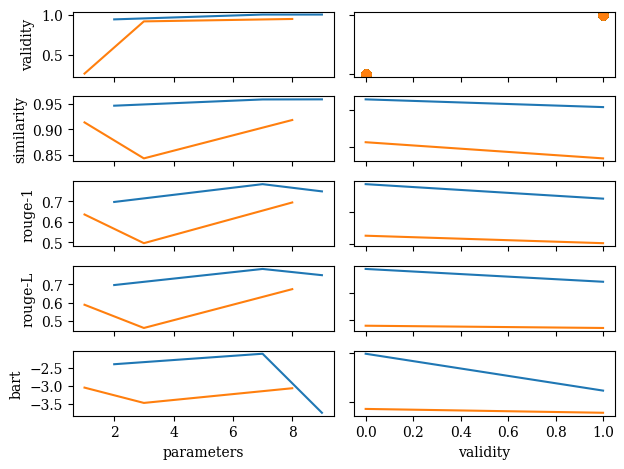

In [25]:
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=WordPunctTokenizer())
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

counterfactuals = []
for model in RESULTS:
    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']

        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)

        counterfactuals.append({
            'type':       model.split()[0].lower(),
            'parameters': int(model[-2]),
#            'depth':      r['hidden_states'].shape[1],
            'validity':   int(success),
            'similarity': cf['similarity'],
            'rouge-1':    rouge['rouge1'].fmeasure,
            'rouge-L':    rouge['rougeL'].fmeasure,
            'bart':       bart[0]
        })

counterfactuals = pd.DataFrame(counterfactuals)
#columns_x = ['depth', 'parameters', 'validity']
columns_x = ['parameters', 'validity']
columns_y = ['validity', 'similarity', 'rouge-1', 'rouge-L', 'bart']

fig, axs = plt.subplots(len(columns_y), len(columns_x))
for i, x in enumerate(columns_x):
    for j, y in enumerate(columns_y):
        for tp in counterfactuals['type'].unique():
            values = counterfactuals[counterfactuals['type']==tp][[x, y]]

            if x != y:
                values = values.groupby(x).mean()
                axs[j,i].plot(values.index, values.values, label=tp)

            else: axs[j,i].scatter(values[x].values, values[y].values, label=tp)

        if j == len(columns_y)-1: axs[j,i].set_xlabel(x)
        else: axs[j,i].set_xticklabels([])

        if i == 0: axs[j,i].set_ylabel(y)
        else: axs[j,i].set_yticklabels([])

fig.tight_layout()
fig.show()